# Predicción espacial de movimientos en masa utilizando ML

Los movimientos en masa (MenM) son responsables de cerca del 17 % de las muertes ocasionadas por amenazas naturales alrededor del mundo. Estas pérdidas humanas se dan predominantemente en países en vías de desarrollo por la combinación de diferentes factores geológicos y antrópicos que, bajo ciertas condiciones hidrometeorológicas, desencadenan movimientos en masa. En contraste, países desarrollados como Estados Unidos y Japón reportan pocas pérdidas humanas, pero altas pérdidas económicas anuales, estimadas entre 1 y 6 mil de millones de dólares.

De manera que la zonificación de la susceptibilidad (predicción espacial) por movimientos en masa resulta un insumo fundamental para la ordenación y planificación de los territorios, y es alli donde es posible aprovechar las ventajas que las técnicas de aprendizaje de máquinas ofrecen, asi como también es importante conocer sus limitaciones.

En el presente trabajo, se utilizó como caso de estudio la cuenca de la quebrada La Miel, en el municipio de Caldas (Antioquia), para implementar y explorar los diferentes métodos de Aprendizaje Automático para la evaluación de la susceptibilidad por movimiento en masa. Lo anterior con el objetivo de establecer un desarrollo metodológico que considere las ventajas y limitaciones de cada uno de los métodos disponibles. Para evaluar la capacidad de predicción se utilizaron las métricas de validación, matriz de confusión, curva ROC (Receiver Operating Characteristic, por sus siglas en inglés), y área bajo la curva AUC (Area Under Curve, por sus siglas en inglés).

## Metolodogía

La secuencia metodológica implementada en el presente estudio se resume en los siguientes cinco pasos: 

1) Elaboración del inventario de movimientos en masa
2) Análisis exploratorio de datos y selección de variables
3) Aplicación de algoritmos de ML
4) Validación de los modelos 
5) Generación de mapas de susceptibilidad

## Inventario de movimientos en masa

Para la elaboración de la base de datos del proyecto (inventario de movimientos en masa) de la zona de estudio se realizó una fotointerpretación, utilizando un estereoscopio de espejos con fotografías aéreas de los años 2010-2011 a escala 1:10000. Para la digitalización se utilizó la ortofotografía de la cuenca y se digitalizaron como líneas las coronas de cada uno de los movimientos en masa identificados en las fotografías aéreas, considerando que dichas características representan las condiciones previas a la ocurrencia del evento. Se identificaron 105 movimientos en masa tipo planares y superficiales. El inventario fue complementado con 32 movimientos en masa históricos consultados en el Sistema de Información de Movimientos en Masa (http://simma.sgc.gov.co/) del Servicio Geológico Colombiano (SGC).  El inventario es la variable dependiente u objetivo, se quiere predecir la probabilidad de que en una celda pueda ocurrir un movimiento en masa.

El formato de esta base de datos es de tipo RASTER, es decir, pixeles de 5 m x 5 m donde cada uno de ellos tiene un valor dependiendo si la celda hace parte de un movimiento en masa. Los valores de 0 corresponden a celdas sin movimientos en masa y los de 0 a celdas con movimientos en masa. Para el manejo de este tipo de formatos espaciales el python es necesario usar librerias que lean este tipo de archivos, como raster io.

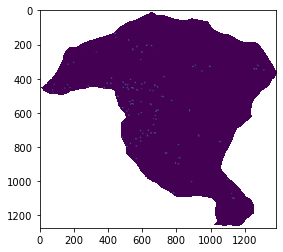

In [1]:
#Se importan las librerias necesarias
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
import seaborn as sns

#Se importa el inventario de movimientos en masa (base de datos)

'inventario'

raster = rio.open(r'C:\Users\JP\Desktop\Proyecto Final ML\Variables3\inventario.tif') #Primero se importa el archivo en la ruta donde está ubicado

inventario=raster.read(1)  #Posteriormente se lee el inventario, el (1) significa la capa que se quiere leer, ya que las imagenes satelitales usualmente tienen mas de una capa.

raster_mask = rio.open(r'C:\Users\JP\Desktop\Proyecto Final ML\Variables3\pendiente.tif') #Para poder visualizar el área de la cuenca se debe crear una "mascara" a partir de otra variable, en este caso la variable pendiente. 

msk=raster_mask.read_masks(1) #Se lee la mascara

msk=np.where(msk==255,1,np.nan) #La máscara por defecto genera un mapa de valores cero para cualquier celda fuera de la cuenca y 255 para celdas que son parte de la cuenca. Modificamos esta máscara para que las celdas por fuera de la cuenca tengan un valor NaN.  

inventario=msk*inventario  #se multiplica el inventario por la mascara y obtenemos el siguiente mapa, donde las celdas dentro de la cuenca que tienen MenM tienen un valor de 1 y sin MenM tienen un valor de 0.      

show(inventario) #se usa para mostrar el mapa

#Para poder explorar variables con ubicación espacial es necesario pasarlas a vectores, para despues formar un dataframe con todas las variables.

inventario_vector=inventario.ravel() #se crea el vector
inventario_vector_MenM=inventario_vector[~np.isnan(inventario_vector)] #se eliminan los NaN


## Variables Predictoras

El procedimiento descrito anteriormente es repetido para todas las variables predictoras. En este trabajo se construyeron un total de 14 variables predictoras, de tipo continuas y categóricas utilizando el software Arcgis 10.5. Las variables continuas fueron: pendiente, aspecto, rugosidad, curvatura de perfil, curvatura plana, curvatura estándar, elevación, Stream Power Index (SPI), Topographic Wetness Index (TWI) y acumulación de flujo; dichas variables fueron obtenidas a partir del Modelo Digital de Elevación con resolución espacial de 5 m x 5 m elaborado por el Instituto Geográfico Agustín Codazzi (IGAC) en el proyecto denominado CartoAntioquia. Las variables categóricas utilizadas fueron: geología, elaborada a escala 1:10000 por el estudio de Microzonificación Sísmica del Valle de Aburrá (AMVA, 2006), distancia a fallas, distancia a drenajes, y finalmente el mapa de coberturas del suelo elaborado con las fotografías aéreas de los años 2010-2011 las cuales fueron georreferenciadas y digitalizadas.

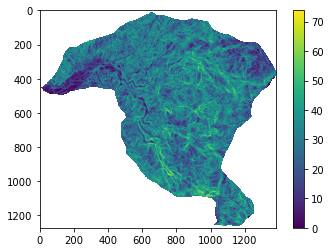

In [2]:
'Pendiente'

raster = rio.open(r'C:\Users\JP\Desktop\Proyecto Final ML\Variables3\pendiente.tif')
pendiente = raster.read(1)
pendiente=np.where(pendiente==-9999,np.nan,pendiente) #En Arcgis los nan fueron reclasificados por -9999, en esta linea se cambian por NaN
plt.imshow(pendiente)
plt.colorbar()

pendiente_vector=pendiente.ravel()
pendiente_vector2=np.nan_to_num(pendiente_vector)
pendiente_vector_MenM=pendiente_vector[~np.isnan(pendiente_vector)] 


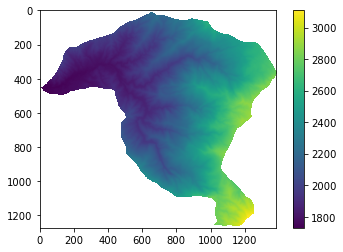

In [3]:
'Elevación'

raster = rio.open(r'C:\Users\JP\Desktop\Proyecto Final ML\Variables3\elevacion.tif')
elevación = raster.read(1)
elevación=np.where(elevación==2147483647,np.nan,elevación)
plt.imshow(elevación)
plt.colorbar()

elevación_vector=elevación.ravel()
elevación_vector2=np.nan_to_num(elevación_vector)
elevación_vector_MenM=elevación_vector[~np.isnan(elevación_vector)]

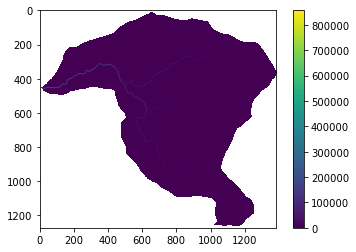

In [4]:
'flow accumulation'

raster = rio.open(r'C:\Users\JP\Desktop\Proyecto Final ML\Variables3\flow_acc.tif')
flow = raster.read(1)
flow=np.where(flow==-9999,np.nan,flow)
plt.imshow(flow)
plt.colorbar()

flujo_vector=flow.ravel()
flujo_vector2=np.nan_to_num(flujo_vector)
flujo_vector_MenM=flujo_vector[~np.isnan(flujo_vector)]

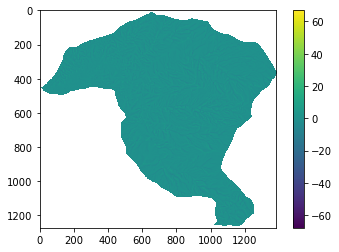

In [5]:
'Curvatura plana'

raster = rio.open(r'C:\Users\JP\Desktop\Proyecto Final ML\Variables3\curv_plan.tif')
curvatura_plan = raster.read(1)
curvatura_plan=np.where(curvatura_plan==-9999,np.nan,curvatura_plan)
plt.imshow(curvatura_plan)
plt.colorbar()

curvatura_plan_vector=curvatura_plan.ravel()
curvatura_plan_vector2=np.nan_to_num(curvatura_plan_vector)
curvatura_plan_vector_MenM=curvatura_plan_vector[~np.isnan(curvatura_plan_vector)]

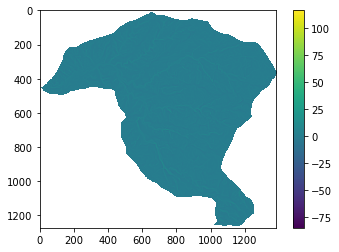

In [6]:
'Curvatura perfil'

raster = rio.open(r'C:\Users\JP\Desktop\Proyecto Final ML\Variables3\curv_perfil.tif')
curvatura_perfil = raster.read(1)
curvatura_perfil=np.where(curvatura_perfil==-9999,np.nan,curvatura_perfil)
plt.imshow(curvatura_perfil)
plt.colorbar()

curvatura_perfil_vector=curvatura_perfil.ravel()
curvatura_perfil_vector2=np.nan_to_num(curvatura_perfil_vector)
curvatura_perfil_vector_MenM=curvatura_perfil_vector[~np.isnan(curvatura_perfil_vector)]

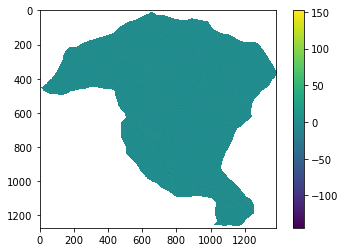

In [7]:
'Curvatura estándar'

raster = rio.open(r'C:\Users\JP\Desktop\Proyecto Final ML\Variables3\curv_estandar.tif')
curvatura_estandar = raster.read(1)
curvatura_estandar=np.where(curvatura_estandar==-9999,np.nan,curvatura_estandar)
plt.imshow(curvatura_estandar)
plt.colorbar()

curvatura_estandar_vector=curvatura_estandar.ravel()
curvatura_estandar_vector2=np.nan_to_num(curvatura_estandar_vector)
curvatura_estandar_vector_MenM=curvatura_estandar_vector[~np.isnan(curvatura_estandar_vector)]

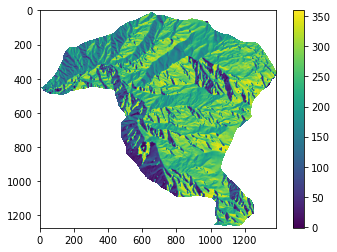

In [8]:
'Aspecto'

raster = rio.open(r'C:\Users\JP\Desktop\Proyecto Final ML\Variables3\aspecto.tif')
ASPECT=raster.read(1)
ASPECT=np.where(ASPECT==-9999,np.nan,ASPECT)
plt.imshow(ASPECT);
plt.colorbar();

aspecto_vector=ASPECT.ravel()
aspecto_vector2=np.nan_to_num(aspecto_vector)
aspecto_vector_MenM=aspecto_vector[~np.isnan(aspecto_vector)]

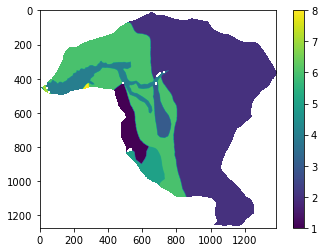

In [9]:
'Geología'

raster = rio.open(r'C:\Users\JP\Desktop\Proyecto Final ML\Variables3\geologia.tif')
geologia=raster.read(1)
geologia=np.where(geologia==-9999,np.nan,geologia)

geologia_vector=geologia.ravel()
geologia_vector2=np.nan_to_num(geologia_vector)
geologia_vector_MenM=geologia_vector[~np.isnan(geologia_vector)]

geo=np.ndarray.tolist(geologia_vector_MenM)
for i in range(211):   #en esta iteración se agregaron aleatoriamente valores cercanos a unas celdas que no tenian valores de geologia, probablemente porque alli no habia cartografia.
    a=np.random.randint(2,4)
    geo.append(a)
    
geologia_vector_MenM=np.asarray(geo)
plt.imshow(geologia);
plt.colorbar();

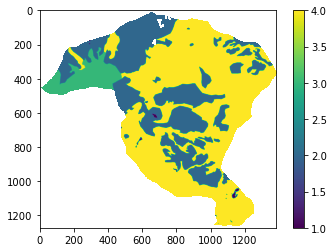

In [10]:
'Coberturas'

raster = rio.open(r'C:\Users\JP\Desktop\Proyecto Final ML\Variables3\coberturas.tif')
coberturas=raster.read(1)
coberturas=np.where(coberturas==-9999,np.nan,coberturas)
plt.imshow(coberturas);
plt.colorbar();

coberturas_vector=coberturas.ravel()
coberturas_vector2=np.nan_to_num(coberturas_vector)

coberturas_vector_MenM=coberturas_vector[~np.isnan(coberturas_vector)]
cob=np.ndarray.tolist(coberturas_vector_MenM)
for i in range(347): #en esta iteración se agregaron aleatoriamente valores cercanos a unas celdas que no tenian valores de coberturas, probablemente porque alli no habia cartografia.
    a=np.random.randint(2,4)
    cob.append(a)
    
coberturas_vector_MenM=np.asarray(cob)

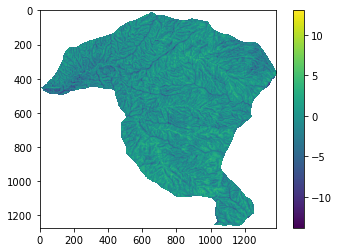

In [11]:
'SPI'

raster = rio.open(r'C:\Users\JP\Desktop\Proyecto Final ML\Variables3\spi.tif')
spi = raster.read(1)
spi=np.where(spi==-9999,np.nan,spi)
plt.imshow(spi)
plt.colorbar()

spi_vector=spi.ravel()
spi_vector2=np.nan_to_num(spi_vector)
spi_vector_MenM=spi_vector[~np.isnan(spi_vector)]

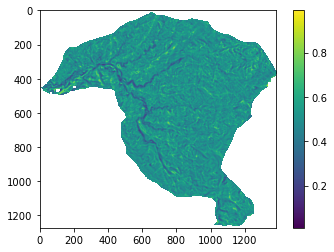

In [12]:
'Rugosidad'

raster = rio.open(r'C:\Users\JP\Desktop\Proyecto Final ML\Variables3\rugo10cut.tif')
rugosidad = raster.read(1)
rugosidad=np.where(rugosidad==-9999,np.nan,rugosidad)
plt.imshow(rugosidad)
plt.colorbar()

rugosidad_vector=rugosidad.ravel()
rugosidad_vector2=np.nan_to_num(rugosidad_vector)
rugosidad_vector_MenM=rugosidad_vector[~np.isnan(rugosidad_vector)]

rug=np.ndarray.tolist(rugosidad_vector_MenM)
for i in range(382):
    a=np.random.randint(0,1)
    rug.append(a)
    
rugosidad_vector_MenM=np.asarray(rug)

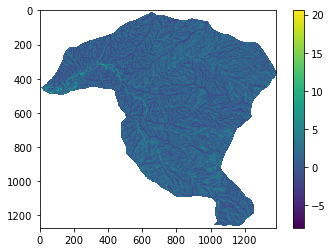

In [13]:
'TWI'

raster = rio.open(r'C:\Users\JP\Desktop\Proyecto Final ML\Variables3\twi.tif')
twi = raster.read(1)
twi=np.where(twi==-9999,np.nan,twi)
plt.imshow(twi)
plt.colorbar()

twi_vector=twi.ravel()
twi_vector2=np.nan_to_num(twi_vector)
twi_vector_MenM=twi_vector[~np.isnan(twi_vector)]

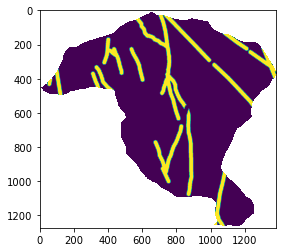

In [14]:

'Buffer lineamientos'

raster = rio.open(r'C:\Users\JP\Desktop\Proyecto Final ML\Variables3\buffer_line.tif')
buffer_line=raster.read(1)
raster_mask = rio.open(r'C:\Users\JP\Desktop\Proyecto Final ML\Variables3\pendiente.tif')
msk=raster_mask.read_masks(1)
msk=np.where(msk==255,1,np.nan)
buffer_line=msk*buffer_line
show(buffer_line)

buffer_line_vector=buffer_line.ravel()
buffer_line_vector2=np.nan_to_num(buffer_line_vector)
buffer_line_vector_MenM=buffer_line_vector[~np.isnan(buffer_line_vector)]

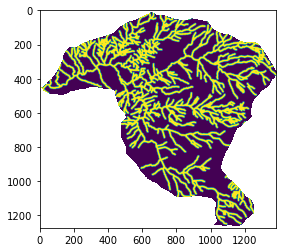

In [15]:
'Buffer_drenajes'

raster = rio.open(r'C:\Users\JP\Desktop\Proyecto Final ML\Variables3\buffer_dren.tif')
buffer_dren=raster.read(1)
raster_mask = rio.open(r'C:\Users\JP\Desktop\Proyecto Final ML\Variables3\pendiente.tif')
msk=raster_mask.read_masks(1)
msk=np.where(msk==255,1,np.nan)
buffer_dren=msk*buffer_dren
show(buffer_dren)

buffer_dren_vector=buffer_dren.ravel()
buffer_dren_vector2=np.nan_to_num(buffer_dren_vector)
buffer_dren_vector_MenM=buffer_dren_vector[~np.isnan(buffer_dren_vector)]

## Análisis Exploratorio de datos

Uno de los pasos más importantes que permite asegurar resultados óptimos al final del procedimiento, se basa en la revisión, depuración y selección de variables. Para esto, se realizó un análisis exploratorio de los datos, que consistió en la elaboración de histogramas con y
sin movimientos en masa para determinar qué variables mostraban diferencias en sus valores ante un movimiento en masa; se elaboraron y analizaron diagramas de dispersión y matriz de correlación con el fin de observar qué variables se encontraban correlacionadas para evitar incluir ruido en los modelos y, finalmente, se usó la técnica no supervisada de Análisis de Componentes Principales, que reduce la dimensionalidad de un problema (cantidad de variables) seleccionando aquellas variables que recojan la mayor parte de variabilidad de los datos, perdiendo la menor cantidad de información posible.

In [16]:
#se crea un dataframe con todos los vectores de las variables predictoras, creados en el paso anterior
d={'inventario':inventario_vector_MenM,'geologia':geologia_vector_MenM,'Rugosidad':rugosidad_vector_MenM,'coberturas':coberturas_vector_MenM,'Buffer Drenajes':buffer_dren_vector_MenM,'Buffer Lineamientos':buffer_line_vector_MenM,'Pendiente':pendiente_vector_MenM,'Flujo Acumulado':flujo_vector_MenM,'Aspecto':aspecto_vector_MenM,
   'Curvatura Perfil':curvatura_perfil_vector_MenM,'Curvatura Plana':curvatura_plan_vector_MenM,'Curvatura Estándar':curvatura_estandar_vector_MenM,'SPI':spi_vector_MenM,'TWI':twi_vector_MenM,'Elevación':elevación_vector_MenM}

data = pd.DataFrame(d)
data.head()

,inventario,geologia,Rugosidad,coberturas,Buffer Drenajes,Buffer Lineamientos,Pendiente,Flujo Acumulado,Aspecto,Curvatura Perfil,Curvatura Plana,Curvatura Estándar,SPI,TWI,Elevación
0,0.0,2.0,0.757568,2.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-0.0,-13.815511,0.0,2255.0
1,0.0,2.0,0.695984,2.0,30.0,0.0,0.0,0.0,-1.0,0.0,0.0,-0.0,-13.815511,0.0,2255.0
2,0.0,2.0,0.690715,2.0,30.0,0.0,0.0,0.0,-1.0,0.0,0.0,-0.0,-13.815511,0.0,2255.0
3,0.0,2.0,0.681966,2.0,30.0,0.0,0.0,0.0,-1.0,0.0,0.0,-0.0,-13.815511,0.0,2255.0
4,0.0,2.0,0.668518,2.0,30.0,0.0,0.0,0.0,-1.0,0.0,0.0,-0.0,-13.815511,0.0,2255.0


Se crea una matriz unicamente de las variables predictoras, para ver su estádistica básica. Además, que se puede observar la cantidad de pixeles de cada variable, en este caso 887282.

In [17]:
matriz_cont=data.drop(['geologia', 'coberturas', 'inventario'],1)
resumen=matriz_cont.describe()
resumen.head()

C:\Users\JP\AppData\Local\Temp/ipykernel_17212/1195287135.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  matriz_cont=data.drop(['geologia', 'coberturas', 'inventario'],1)


,Rugosidad,Buffer Drenajes,Buffer Lineamientos,Pendiente,Flujo Acumulado,Aspecto,Curvatura Perfil,Curvatura Plana,Curvatura Estándar,SPI,TWI,Elevación
count,887282.000000,887282.000000,887282.000000,887282.000000,887282.000000,887282.000000,887282.000000,887282.000000,887282.000000,887282.000000,887282.000000,887282.000000
mean,0.506659,10.797954,7.859733,29.429579,1006.045471,208.949661,0.009249,0.011737,0.000000,-0.534607,0.847492,2263.076530
std,0.082455,14.399411,20.243741,11.475101,21749.802734,103.518028,5.412141,4.558727,8.814255,4.140021,3.979296,324.650286
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-85.146645,-67.692307,-144.000000,-13.815511,-7.977101,1730.000000
25%,0.461114,0.000000,0.000000,21.954998,1.000000,143.746155,-3.440000,-2.594594,-4.000000,-0.912794,0.341192,1985.000000


También es importante saber cuantas celdas pertenecen a movimiento en masa y cuales no, es decir, cuantas son 0 y 1. En este caso en particular de 887282 celdas solo 1453 son movimientos en masa, es decir, el 0.16% de las celdas. Esto nos ayuda a observar que es un problema de clases desbalanceadas y que vamos a necesitar técnicas de remuestreo para modelar con algoritmos de ML, ya que si esto no se hace, los modelos aprenderán únicamente a predecir 0, los cuales en este caso no tienen la misma relevancia que predecir los 1.

In [18]:
#Para contar el numero de celdas con y sin MenM
data['inventario'].value_counts()


0.0    885829
1.0      1453
Name: inventario, dtype: int64

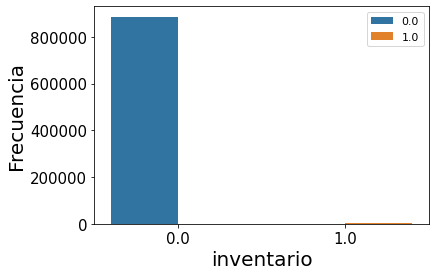

In [19]:
#histograma del inventario
ax = sns.countplot(data=data, x = 'inventario', hue = 'inventario')
ax.tick_params('both', colors='k', labelsize= 15)
ax.set_xlabel('inventario', color='k', size=20)
ax.set_ylabel('Frecuencia', color='k', size=20)
ax.legend(loc=1, fontsize=11)
plt.show()

Con esta agrupación se da una idea de que valores promedios están relacionados con las celdas 1, es decir, las celdas con MenM.

In [20]:
#Para saber la media de cada variable independiente de acuerdo con la variable dependiente
media=data.groupby('inventario').mean()
print(media)

            geologia  Rugosidad  coberturas  Buffer Drenajes  \
inventario                                                     
0.0         3.188084   0.506648    3.255547        10.805404   
1.0         4.362010   0.513257    3.225740         6.256022   

            Buffer Lineamientos  Pendiente  Flujo Acumulado     Aspecto  \
inventario                                                                
0.0                    7.868900  29.429083      1010.164368  208.985336   
1.0                    2.271163  28.962366        16.790089  182.732605   

            Curvatura Perfil  Curvatura Plana  Curvatura Estándar       SPI  \
inventario                                                                    
0.0                 0.010233         0.011231           -0.001495 -0.533348   
1.0                -0.591045         0.320173            0.911218 -1.269143   

                 TWI    Elevación  
inventario                         
0.0         0.848553  2263.409185  
1.0         0.173

## Histogramas

Para la selección de variables se realizaron histogramas de cada una de las variables diferenciando las celdas con deslizamientos y las celdas con no deslizamientos. Las variables elevación, TWI, SPI, curvaturas (plana, perfil, estándar), aspecto, flujo acumulado, buffer drenajes y geología exhiben un comportamiento distinto cuando ocurre un movimiento en masa, por lo que se consideraron como buenas variables predictoras; caso contrario ocurre con la rugosidad, pendiente y buffer lineamientos ya que no se diferenciaron en términos de movimientos en masa, por lo que no son variables predictoras adecuadas.

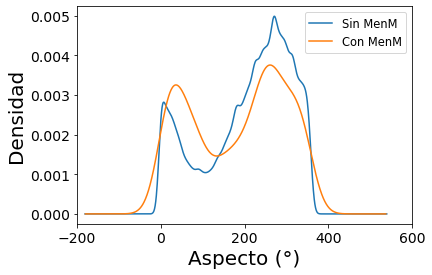

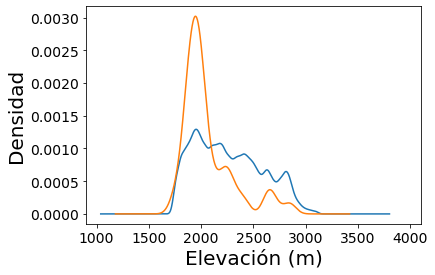

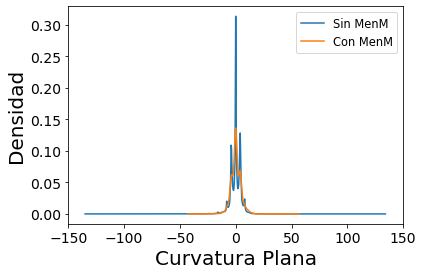

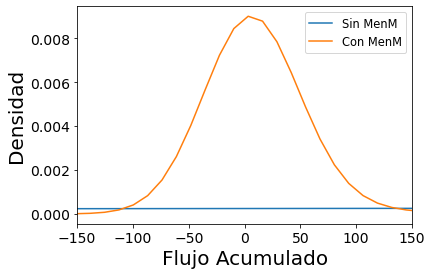

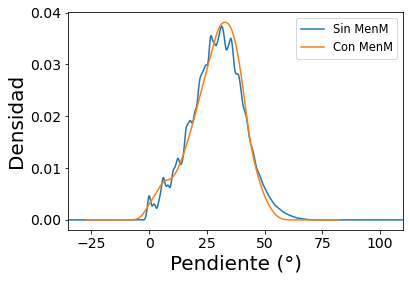

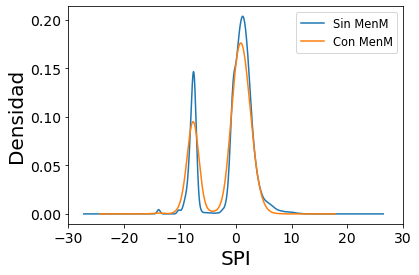

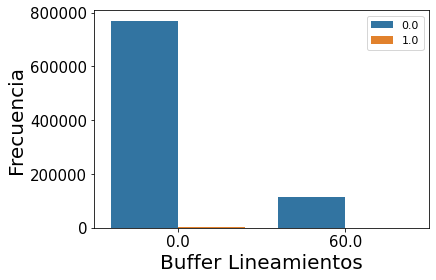

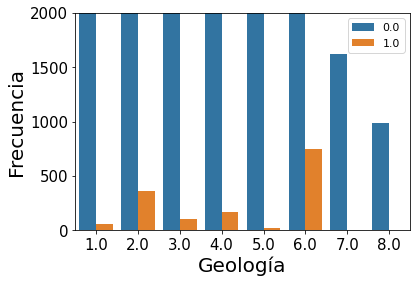

In [21]:
#Histograma de frecuencia para CON y SIN MenM

'aspecto'

data_sin=data[(data['inventario']==0)]
data_con=data[(data['inventario']==1)]
fig, ax = plt.subplots()
data_sin['Aspecto'].plot.kde(ax=ax, label='Sin MenM')
data_con['Aspecto'].plot.kde(ax=ax, label='Con MenM')
ax.set_xlabel('Aspecto (°)', color='k', size=20)
ax.set_ylabel('Densidad', color='k', size=20)
ax.tick_params('y', colors='k', labelsize= 14)
ax.tick_params('x', colors='k', labelsize= 14)
ax.set_xlim(-200,600)
ax.legend(loc=1, fontsize=11.5)
plt.show()


'elevación'
data_sin=data[(data['inventario']==0)]
data_con=data[(data['inventario']==1)]
fig, ax = plt.subplots()
data_sin['Elevación'].plot.kde(ax=ax, label='Sin MenM')
data_con['Elevación'].plot.kde(ax=ax, label='Con MenM')
ax.set_xlabel('Elevación (m)', color='k', size=20)
ax.set_ylabel('Densidad', color='k', size=20)
ax.tick_params('y', colors='k', labelsize= 14)
ax.tick_params('x', colors='k', labelsize= 14)
ax.set_xlim(900,4100)
plt.show()


ax.legend(loc=1, fontsize=11.5)
ax.get_legend().set_visible(False)

'curvatura plana'

data_sin=data[(data['inventario']==0)]
data_con=data[(data['inventario']==1)]
fig, ax = plt.subplots()
data_sin['Curvatura Plana'].plot.kde(ax=ax, label='Sin MenM')
data_con['Curvatura Plana'].plot.kde(ax=ax, label='Con MenM')
ax.set_xlabel('Curvatura Plana', color='k', size=20)
ax.set_ylabel('Densidad', color='k', size=20)
ax.tick_params('y', colors='k', labelsize= 14)
ax.tick_params('x', colors='k', labelsize= 14)
ax.set_xlim(-150,150)
ax.legend(loc=1, fontsize=11.5)
plt.show()

'flujo acumulado'

data_sin=data[(data['inventario']==0)]
data_con=data[(data['inventario']==1)]
fig, ax = plt.subplots()
data_sin['Flujo Acumulado'].plot.kde(ax=ax, label='Sin MenM')
data_con['Flujo Acumulado'].plot.kde(ax=ax, label='Con MenM')
ax.set_xlabel('Flujo Acumulado', color='k', size=20)
ax.set_ylabel('Densidad', color='k', size=20)
ax.tick_params('y', colors='k', labelsize= 14)
ax.tick_params('x', colors='k', labelsize= 14)
ax.set_xlim(-150,150)
ax.legend(loc=1, fontsize=11.5)
plt.show()


'pendiente'

data_sin=data[(data['inventario']==0)]
data_con=data[(data['inventario']==1)]
fig, ax = plt.subplots()
data_sin['Pendiente'].plot.kde(ax=ax, label='Sin MenM')
data_con['Pendiente'].plot.kde(ax=ax, label='Con MenM')
ax.set_xlabel('Pendiente (°)', color='k', size=20)
ax.set_ylabel('Densidad', color='k', size=20)
ax.tick_params('y', colors='k', labelsize= 14)
ax.tick_params('x', colors='k', labelsize= 14)
ax.set_xlim(-35,110)
ax.legend(loc=1, fontsize=11.5)
plt.show()


'SPI'

data_sin=data[(data['inventario']==0)]
data_con=data[(data['inventario']==1)]
fig, ax = plt.subplots()
data_sin['SPI'].plot.kde(ax=ax, label='Sin MenM')
data_con['SPI'].plot.kde(ax=ax, label='Con MenM')
ax.set_xlabel('SPI', color='k', size=20)
ax.set_ylabel('Densidad', color='k', size=20)
ax.tick_params('y', colors='k', labelsize= 14)
ax.tick_params('x', colors='k', labelsize= 14)
ax.set_xlim(-30,30)
ax.legend(loc=1, fontsize=11.5)
plt.show()

'Buffer lineamientos'

ax = sns.countplot(data=data, x = 'Buffer Lineamientos', hue = 'inventario')
ax.tick_params('both', colors='k', labelsize= 15)
ax.set_xlabel('Buffer Lineamientos', color='k', size=20)
ax.set_ylabel('Frecuencia', color='k', size=20)
ax.legend(loc=1, fontsize=11)
plt.show()

'geología'

ax = sns.countplot(data=data, x = 'geologia', hue = 'inventario')
ax.tick_params('both', colors='k', labelsize= 15)
ax.set_ylim(0,2000)
ax.set_xlabel('Geología', color='k', size=20)
ax.set_ylabel('Frecuencia', color='k', size=20)
ax.legend(loc=1, fontsize=11)
plt.show()

## Diagramas de dispersión

Otra herramienta útil son los diagramas de dispersión. Estos nos permite verificar si dos variables están correlacionadas entre si, y asi mismo evitar redundancia en las variables y en los modelos, ya que sería equivalen a agregar ruido al mismo. En general, las diferentes tipos de curvaturas están correlacionadas, y algunos indices como el SPI y el TWI. Sin embargo, tambien existen variables como la elevación vs el flujo acumulado, que no guardan ninguna relación. 

c:\Users\JP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\JP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\JP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\JP\anaconda3\lib\site-

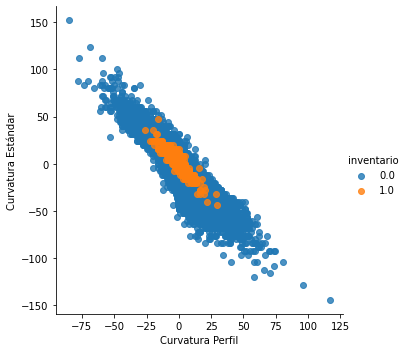

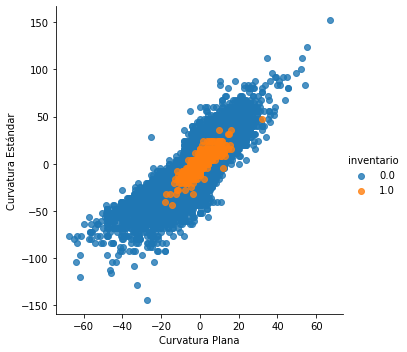

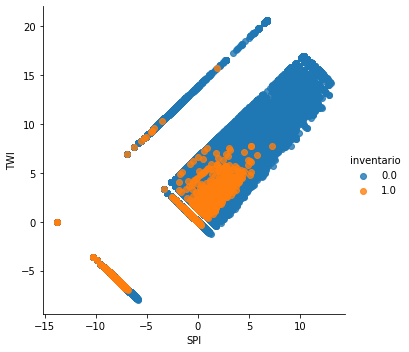

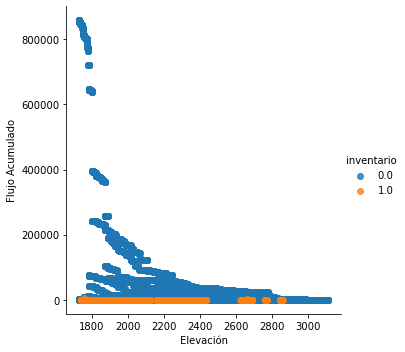

In [22]:
'Matriz de scattering'

sns.lmplot('Curvatura Perfil', 'Curvatura Estándar', data=data, hue='inventario', fit_reg=False);
sns.lmplot('Curvatura Plana', 'Curvatura Estándar', data=data, hue='inventario', fit_reg=False);
sns.lmplot('SPI', 'TWI', data=data, hue='inventario', fit_reg=False);
sns.lmplot('Elevación', 'Flujo Acumulado', data=data, hue='inventario', fit_reg=False);

## Matriz de correlación

Una manera general de observar la correlación entre todas las variables del data set es con la matriz de correlación de Pearson. Para el caso del data set del proyecto, en general, se observan valores de correlación bajos y positivos. Sólo las variables curvatura plana y curvatura estándar presentan una correlación negativa media con las variables SPI y TWI; y la variable curvatura perfil una correlación positiva media con curvatura estándar y curvatura plana.

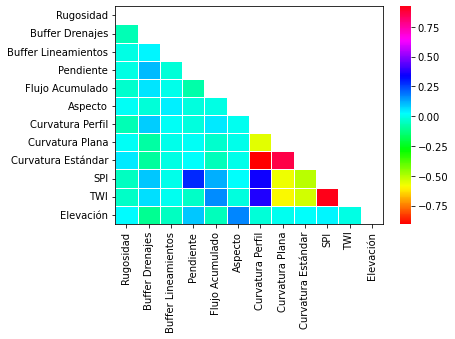

In [23]:
#Matriz de correlacion de Pearson y mapa de calor
matrix = np.triu(matriz_cont.corr())
ax = sns.heatmap(matriz_cont.corr(), mask=matrix, cmap='hsv',linewidths=1, linecolor='white')
for _, spine in ax.spines.items():
    spine.set_visible(True)
plt.show()

## Análisis de Componentes Principales

Se utilizó la técnica de aprendizaje no supervisado de análisis de componentes principales para reducir la dimensionalidad del problema, es decir, reducir el número de variables perdiendo la menor cantidad de información posible, esto es combinado con el análisis exploratorio de datos para hacer una depuración de todas las variables y dejar las que sean mas  explicativas para el modelo.

El PCA arrojó que los 6 primeros componentes explican aproximadamente el 75% de la varianza del problema donde las variables que más aportan a la varianza, y que están en dirección de los puntos con MenM son: curvatura estándar, geología, flujo acumulado, curvatura perfil, pendiente, elevación, SPI, y buffer drenajes.

C:\Users\JP\AppData\Local\Temp/ipykernel_15484/2011670956.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  matriz = data.drop(['inventario'], 1)


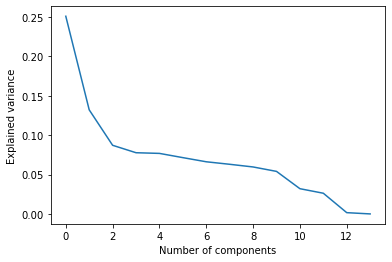

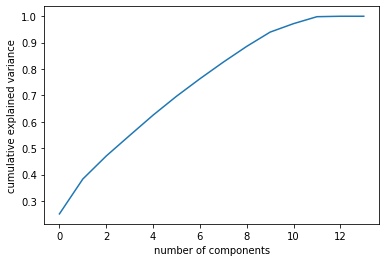

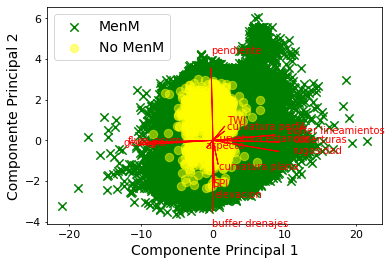

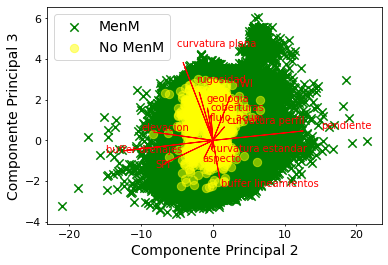

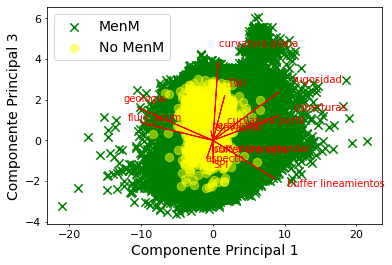

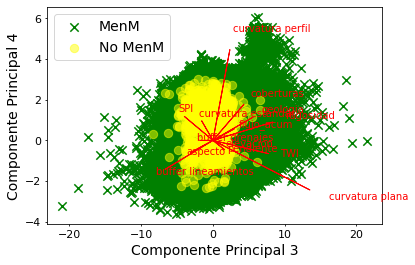

In [24]:
#Se importan las librerias necesarias
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

matriz = data.drop(['inventario'], 1)
#Antes de aplicar PCA se debe escalar la matriz con todas las variables, menos el inventario
matriz = pd.DataFrame(scale(matriz), columns=['pendiente', 'aspecto', 'elevacion', 'TWI', 'curvatura estandar', 'curvatura plana', 'curvatura perfil', 'SPI', 'buffer lineamientos', 'flujo_acum', 'geologia', 'rugosidad', 'coberturas', 'buffer drenajes'])

# Se implementa el análisi PCA con la libreria sklearn de python
n = len(matriz.columns)
pca = PCA(n_components=n).fit(matriz)
pca_samples = pca.transform(matriz)

#Se puede graficar cuanto aporta a la varianza cada componente generado
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

#graficamos el acumulado de varianza explicada en las nuevas dimensiones
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

#Para identificar cada variable como se relaciona con las componentes utilizamos las figuras byplot de python
# 0,1 denota el componente princiapl 1 y 2 (PC1 and PC2); para otros componentes se modifica el número
'Componentes 1 y 2 '

xvector = pca.components_[0] 
yvector = pca.components_[1]

xs = pca.transform(matriz)[:,0] 
ys = pca.transform(matriz)[:,1]

mask1=np.ma.masked_where(inventario_vector_MenM < 1,xs )
mask2=np.ma.masked_where(inventario_vector_MenM < 1,ys ) 

for i in range(len(xvector)):
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='r', width=0.0005, head_width=0.0025)
    plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
             list(matriz.columns.values)[i], color='r') 
    
plt.scatter(xs, ys, s=70,marker='x',c='green', label='MenM')
plt.scatter(mask1,mask2,facecolors='yellow', edgecolors='yellow', s=70, alpha=0.5, label='No MenM')
plt.tick_params('y', colors='k', labelsize=11, length=2)
plt.tick_params('x', colors='k', labelsize= 11, length=2)
plt.xlabel("Componente Principal 1", fontsize=14)
plt.ylabel("Componente Principal 2", fontsize=14)
plt.legend(fontsize=14)
plt.savefig("PCA_fin.pdf", dpi=300)
plt.show()


'Componentes 2 y 3 '
xvector = pca.components_[1] 
yvector = pca.components_[2]

xs = pca.transform(matriz)[:,0] 
ys = pca.transform(matriz)[:,1]

mask1=np.ma.masked_where(inventario_vector_MenM < 1,xs )
mask2=np.ma.masked_where(inventario_vector_MenM < 1,ys ) 

for i in range(len(xvector)):
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='r', width=0.0005, head_width=0.0025)
    plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
             list(matriz.columns.values)[i], color='r') 
    
plt.scatter(xs, ys, s=70,marker='x',c='green', label='MenM')
plt.scatter(mask1,mask2,facecolors='yellow', edgecolors='yellow', s=70, alpha=0.5, label='No MenM')
plt.tick_params('y', colors='k', labelsize=11, length=2)
plt.tick_params('x', colors='k', labelsize= 11, length=2)
plt.xlabel("Componente Principal 2", fontsize=14)
plt.ylabel("Componente Principal 3", fontsize=14)
plt.legend(fontsize=14)
plt.show()

'Componentes 1 y 3 '
xvector = pca.components_[0] 
yvector = pca.components_[2]

xs = pca.transform(matriz)[:,0] 
ys = pca.transform(matriz)[:,1]

mask1=np.ma.masked_where(inventario_vector_MenM < 1,xs )
mask2=np.ma.masked_where(inventario_vector_MenM < 1,ys ) 

for i in range(len(xvector)):
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='r', width=0.0005, head_width=0.0025)
    plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
             list(matriz.columns.values)[i], color='r') 
    
plt.scatter(xs, ys, s=70,marker='x',c='green', label='MenM')
plt.scatter(mask1,mask2,facecolors='yellow', edgecolors='yellow', s=70, alpha=0.5, label='No MenM')
plt.tick_params('y', colors='k', labelsize=11, length=2)
plt.tick_params('x', colors='k', labelsize= 11, length=2)
plt.xlabel("Componente Principal 1", fontsize=14)
plt.ylabel("Componente Principal 3", fontsize=14)
plt.legend(fontsize=14)
plt.show()

'Componentes 3 y 4 '
xvector = pca.components_[2] 
yvector = pca.components_[3]

xs = pca.transform(matriz)[:,0] 
ys = pca.transform(matriz)[:,1]

mask1=np.ma.masked_where(inventario_vector_MenM < 1,xs )
mask2=np.ma.masked_where(inventario_vector_MenM < 1,ys ) 
## Para visualizar las proyecciones de cada variable en los componentes se utiliza la siguiente función
for i in range(len(xvector)):
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='r', width=0.0005, head_width=0.0025)
    plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
             list(matriz.columns.values)[i], color='r') 
    
plt.scatter(xs, ys, s=70,marker='x',c='green', label='MenM')
plt.scatter(mask1,mask2,facecolors='yellow', edgecolors='yellow', s=70, alpha=0.5, label='No MenM')
plt.tick_params('y', colors='k', labelsize=11, length=2)
plt.tick_params('x', colors='k', labelsize= 11, length=2)
plt.xlabel("Componente Principal 3", fontsize=14)
plt.ylabel("Componente Principal 4", fontsize=14)
plt.legend(fontsize=14)
plt.show()


Con base en la integración de los análisis anteriormente explicados, se seleccionaron las siguientes variables para construir el modelo: Pendiente, Geología, Curvatura de perfil, TWI, Aspecto, Buffer drenajes, Buffer lineamientos y Elevación.

## Aplicación de modelo de ML- Random Forest

Para la aplicación del modelo, se dividió de manera aleatoria tanto a las variables predictoras (887282 pixeles) como al inventario de movimientos en masa (1453 píxeles), en 80 % de entrenamiento y 20 % de validación. Es importante notar que la ocurrencia de movimientos en masa representa sólo el 0.16 % de todos los píxeles de la cuenca, por lo que se considera un problema desbalanceado en ML. Si se entrena un modelo en el cual la clase que se quiere predecir es minoritaria, el modelo no aprenderá adecuadamente y las predicciones serán sólo de la clase mayoritaria, arrojando altos valores en las métricas de evaluación.

Para afrontar este problema, se utilizó la técnica de submuestreo, utilizando la función RUS (por sus siglas en inglés Random Under Sampler). El modelo implementado fue random forest utilizando el algoritmo de busqueda Random Search, ya que el grid search CV para esta cantidad de datos es poco eficiente, debido a que realiza todas las combinaciones posibles entre toda la grilla de hiperparametros suministrada, por el contrario, el Random Search hace combinaciones aleatorias. La métrica a maximizar fue el recall, esto debido a que el mayor interés es poder predecir correctamente los 1, es decir, las celdas con MenM

In [17]:
#Se hace un nuevo dataframe con las nuevas variables seleccionadas

d={'inventario':inventario_vector_MenM,'geologia':geologia_vector_MenM,
   'buffer drenajes':buffer_dren_vector_MenM,'buffer lineamientos':buffer_line_vector_MenM,
   'pendiente':pendiente_vector_MenM,'aspecto':aspecto_vector_MenM,
   'curvatura perfil':curvatura_perfil_vector_MenM,'TWI':twi_vector_MenM,'elevacion':elevación_vector_MenM}
x = pd.DataFrame(d) #se toma el dataframe como una nueva variable
y=x['inventario'] #se asigna la variable objetivo al inventario
x.drop('inventario', axis=1, inplace=True) # se elimina el inventario de las variables independientes
dummy_geologia=pd.get_dummies(x['geologia'],prefix='geo') #se convierten en dummies las clases de la variable geologia
column_name=x.columns.values.tolist()
column_name.remove('geologia')
x1=x[column_name].join(dummy_geologia) #se agrega geologia a las variables independientes
x1.head()

,buffer drenajes,buffer lineamientos,pendiente,aspecto,curvatura perfil,TWI,elevacion,geo_1.0,geo_2.0,geo_3.0,geo_4.0,geo_5.0,geo_6.0,geo_7.0,geo_8.0
0,0.0,0.0,0.0,-1.0,0.0,0.0,2255.0,0,1,0,0,0,0,0,0
1,30.0,0.0,0.0,-1.0,0.0,0.0,2255.0,0,1,0,0,0,0,0,0
2,30.0,0.0,0.0,-1.0,0.0,0.0,2255.0,0,1,0,0,0,0,0,0
3,30.0,0.0,0.0,-1.0,0.0,0.0,2255.0,0,1,0,0,0,0,0,0
4,30.0,0.0,0.0,-1.0,0.0,0.0,2255.0,0,1,0,0,0,0,0,0


In [18]:
#Se hace el split de la data, 80% entrenamiento, 20% teset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x1, y, test_size=0.2, random_state=1)

In [19]:
'BALANCEAR DATA'

#El submuestreo lleva los 0 a la misma cantidad de los 1

#Se realiza el submuestreo con RUS
from imblearn.under_sampling import RandomUnderSampler
 
rus = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)


In [20]:
from sklearn.ensemble import RandomForestClassifier

#Primero se implementará el modelo con sus hiperparámetros por defecto

model= RandomForestClassifier(random_state=1)
model.fit(X_resampled, y_resampled)
y_pred=model.predict(X_resampled)
probs=model.predict_proba(X_resampled)
probs=probs[:,1]

Luego de ajustar el modelo y hacer las predicciónes se evalua el desempeño del modelo, es decir, con la data de entrenamiento. Aqui se observa que el modelo tiene un desempeño perfecto, sin errores, y el AUC es  1, lo que puede ser una señal de sobre ajuste del modelo.

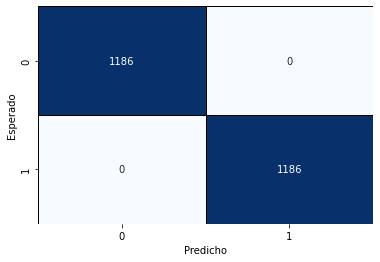

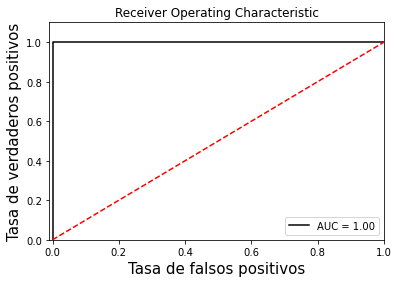

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1186
         1.0       1.00      1.00      1.00      1186

    accuracy                           1.00      2372
   macro avg       1.00      1.00      1.00      2372
weighted avg       1.00      1.00      1.00      2372



In [21]:
#Se importan las librerias de las métricas matriz de confusión y curva ROC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.metrics import classification_report

#Se crea la matriz de confusión
matrix = confusion_matrix(y_resampled, y_pred)

sns.heatmap(matrix, annot=True, cbar=False, linecolor='black',linewidths=0.7, cmap=plt.cm.Blues,fmt='g' )
plt.xlabel('Predicho')
plt.ylabel('Esperado')
plt.show()

#Se crea la curva ROC y el AUC
fpr, tpr, threshold=roc_curve(y_resampled, probs)
roc_auc2 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'k', label = 'AUC = %0.2f' %roc_auc2)
plt.legend(loc = 'lower right')
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.1])
plt.ylabel("Tasa de verdaderos positivos", fontsize=15)
plt.xlabel("Tasa de falsos positivos", fontsize=15)
plt.show()

#Clasification report para ver las métricas de evaluación
report = classification_report(y_resampled, y_pred)
print(report)


Ahora se harán las predicciones con la data de test, data que el modelo nunca ha visto, para observar como es su capacidad de generalización.

In [22]:
model= RandomForestClassifier(random_state=1)
model.fit(X_resampled, y_resampled)
y_pred=model.predict(X_test)
probs=model.predict_proba(X_test)
probs=probs[:,1]

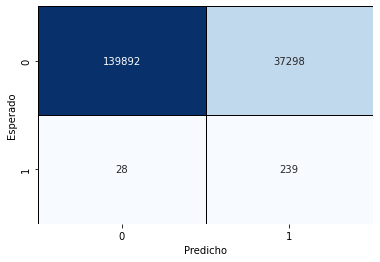

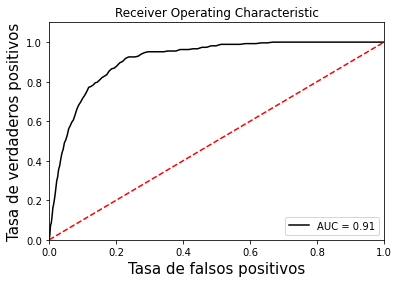

              precision    recall  f1-score   support

         0.0       1.00      0.79      0.88    177190
         1.0       0.01      0.90      0.01       267

    accuracy                           0.79    177457
   macro avg       0.50      0.84      0.45    177457
weighted avg       1.00      0.79      0.88    177457



In [23]:
matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(matrix, annot=True, cbar=False, linecolor='black',linewidths=0.7, cmap=plt.cm.Blues,fmt='g' )
plt.xlabel('Predicho')
plt.ylabel('Esperado')
plt.show()

fpr, tpr, threshold=roc_curve(y_test, probs)
roc_auc2 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'k', label = 'AUC = %0.2f' %roc_auc2)
plt.legend(loc = 'lower right')
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.ylabel("Tasa de verdaderos positivos", fontsize=15)
plt.xlabel("Tasa de falsos positivos", fontsize=15)
plt.show()

report = classification_report(y_test, y_pred)
print(report)

Podemos encontrar el equilibrio entre la tasa de falsos positivos y la tasa de verdaderos positivos calculando el umbral de clasificación perfecta dado por la curva ROC.

In [24]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'threshold' : pd.Series(threshold, index = i)})
best=roc.loc[(roc.tf-0).abs().argsort()[:1]]
print(best)

         fpr       tpr     1-fpr       tf  threshold
45  0.171844  0.835206  0.828156  0.00705       0.56


In [25]:
THRESHOLD = 0.56
y_pred = np.where(model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

A pesar de que aumentaron los falsos positivos, los falsos negativos dismunuyeron significativamente, esto es, el balance entre los dos tipos de errores.

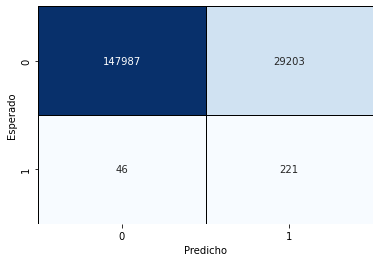

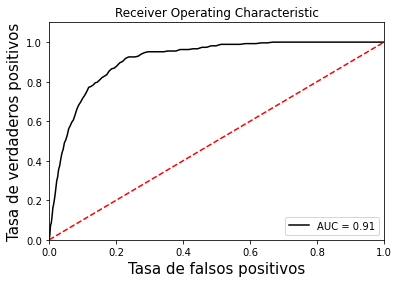

              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91    177190
         1.0       0.01      0.83      0.01       267

    accuracy                           0.84    177457
   macro avg       0.50      0.83      0.46    177457
weighted avg       1.00      0.84      0.91    177457



In [26]:
matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(matrix, annot=True, cbar=False, linecolor='black',linewidths=0.7, cmap=plt.cm.Blues,fmt='g' )
plt.xlabel('Predicho')
plt.ylabel('Esperado')
plt.show()

fpr, tpr, threshold=roc_curve(y_test, probs)
roc_auc2 = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'k', label = 'AUC = %0.2f' %roc_auc2)
plt.legend(loc = 'lower right')
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.ylabel("Tasa de verdaderos positivos", fontsize=15)
plt.xlabel("Tasa de falsos positivos", fontsize=15)
plt.show()

report = classification_report(y_test, y_pred)
print(report)

## Generación del mapa de susceptibilidad final

Luego de tener el modelo final podemos generar el mapa de susceptibilidad final. En este mapa cada celda tiene una probabilidad de ocurrencia de movimientos en masa, las cuales tienen una referencia en el espacio.

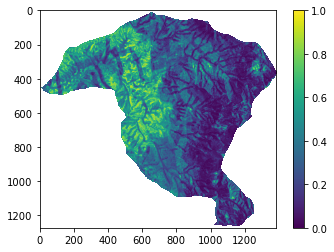

In [31]:
'Exportar mapa'

f = {'geologia':geologia_vector2,
   'buffer drenajes':buffer_dren_vector2,'buffer lineamientos':buffer_line_vector2,
   'pendiente':pendiente_vector2,'aspecto':aspecto_vector2,
   'curvatura perfil':curvatura_perfil_vector2,'TWI':twi_vector2,'elevacion':elevación_vector2}

x_map=pd.DataFrame(f)
dummy_geologia2=pd.get_dummies(x_map['geologia'],prefix='geo')
column_name2=x_map.columns.values.tolist()
column_name2.remove('geologia')
x_map=x_map[column_name2].join(dummy_geologia2)
x_map=x_map.drop('geo_0.0',axis=1)
x_map.head()

x_map2=pd.DataFrame(x_map)
x_map2=x_map2.values

#prediccion para todo el mapa
IS=model.predict(x_map)
IS_prob=model.predict_proba(x_map)
IS_prob2=IS_prob[:,1]



file = rio.open(r'C:\Users\JP\Desktop\Proyecto Final ML\Variables3\pendiente.tif')
pendiente2 = file.read(1)


IS_2=IS_prob2.reshape(pendiente2.shape)
IS_3=np.where(pendiente2==-9999,np.nan,IS_2)
plt.imshow(IS_3)
plt.colorbar()


## Conclusiones

Las herramientas proporcionadas por la Inteligencia Artificial y Aprendizaje Automático se destacan como una excelente alternativa que proporcionan modelos que se pueden ajustar adecuadamente a la realidad del problema enfrentado. Sin embargo, al igual que para las técnicas clásicas de la evaluación de la susceptibilidad por movimientos en masa como métodos heurísticos o con base física, se requiere tener un buen inventario de movimiento en masa, y un detallado levantamiento de las variables predictoras. Estas condiciones básicas permitirán obtener y ajustar modelos útiles para la toma de decisiones y entendimiento del fenómeno.

En cuanto al algoritmo de Random Forest aplicado a la data disponible, cuando fue ejecutado con la data de entrenamiento, su desempeño es perfecto, es decir, hay un problema de sobreajuste de la data. Cuando se realizó la evaluación con la data de test (nunca antes vista por el modelo) las métricas bajan, sin embargo, se mantienen en alrededor del 0.80, lo cual sugiere que es un modelo robusto que capta la complejidad del fenomeno.